# Project scope

Self-development project focused on gaining a practical understanding on how to deploy a CNN for binary classification. I am using tensorflow and a public healthcare dataset from Kaggle. This broadened my understanding on how to pre-process image data suitable for ingestion by a CNN and how to gradually fine tune and build a sequential CNN. Without great lengths, the notebook explains the reasoning behind the chosen steps for: data pre-processing, image augmentation and CNN training. I am also leveraging the computational power of Google Colab to deploy and train algorithms. Aside from the technical implementation it allowed me to get the hang on developing a solution that can support healthcare professionals. References to all resources used are listed below. 

# Data source

The data used in this project can be found on Kaggle and comprises c. 5.8k chest X-ray images (anterior-posterior) of paediatric patients with 1 to 5 years old from Guangzhou Women and Children’s Medical Centre, Guangzhou. You can read more about the data using the following link:
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

# Approach

Data is organized in 3 separate directories: train, validation, and test. Within each there are separate directories for X-ray images with normal lungs and pneumonia lungs. This folder structure allows one to take advantage of keras' ImageDataGenerator function for pre-processing the data. ImageDataGenerator requires low memory usage as it is loading the images in batches, speeding up processing.<br><br>
I have re-organized the validation set since the original folder 
structure had only 16 images for validation. That has been increased to c.280 - 10% of the training set.<br><br> 
Before training, I have set a random seed to allow for reproducibility of results removing the randomness that occurs during training when parameters are initialized.<br><br> 
I opted for using VGG16’s pre-processing specifications as it showed good training performance compared to other set ups. *VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper Very Deep Convolutional Networks for Large-Scale Image Recognition. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes.*<br><br>
Training data was augmented changing shear_range, vertical_flip and zoom_range.<br><br>
Model has 2 convolutional layers with: learning_rate=0.0001, activation='softmax' and optimizer=Adam.<br><br>
Model was set to train for 50 epochs with early stopping for up to an additional 10 epochs without verifying any improvement in the validation loss.<br><br>
The best model was be saved based on improvements in validation loss and model performance was accessed by monitoring accuracy and F1 score improvements. Reasoning for using F1 score comes from the fact that the classes are a bit imbalanced and there could be a serious downside to predicting false negatives (i.e. predicting someone does not have Pneumonia when they do).

# Limitations

A main data limitation is the fact that the model is training on images of a specific age band (and potentially gender), meaning that there is a high chance of it not generalizing well for other age bands.<br><br>
In addition, there are only 5.8k x-ray images that certainly do not include all types of pneumonia. Thus the model might not be able to generalize for "not-seen" types of the disease.<br><br>
For simplicity and to ease up training, I have also limited the complexity of the CNN to have only 2 layers and train across 50 epochs. There could be accuracy gains in adding extra layers or extending the CNN training.  

# Setup

python                    3.9.7<br>
keras                     2.7.0<br>
keras-preprocessing       1.1.2<br>
scikit-learn              1.0.2<br>
tensorflow                2.7.0<br>
tensorflow-estimator      2.7.0<br>

# References

Below are all the references that helped me understand not only the fundamental concepts in CNNs, but also the reasoning behind my data augmentation and hyper parameters choices:<br><br>
**Visualize train images**:<br>
Plotting sample data: https://www.kaggle.com/sanwal092/intro-to-cnn-using-keras-to-predict-pneumonia<br>
**Data Augmentation & Pre-processing**:<br>
Augmentation techniques: https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/<br>
Image Augmentor: https://github.com/mdbloice/Augmentor<br>
ImageDataGenerator: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html<br>
Rescale: https://datascience.stackexchange.com/questions/92499/rescale-parameter-in-data-augmentation<br>
Shearing: https://mathworld.wolfram.com/Shear.html<br>
Batch size: https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network<br>
**Model training**:<br>
deeplizard, Deep Learning Fundamentals: https://www.youtube.com/playlist?list=PLZbbT5o_s2xq7LwI2y8_QtvuXZedL6tQU<br>
deeplizard, TensorFlow Python Deep Learning Neutal Network API: https://www.youtube.com/playlist?list=PLZbbT5o_s2xq7LwI2y8_QtvuXZedL6tQU<br>
deeplizard, Setting random seed: https://deeplizard.com/learn/video/HcW0DeWRggs<br>
VGG16: https://neurohive.io/en/popular-networks/vgg16/<br>


# Code

In [1]:
# Import libraries

import os
import numpy as np
from PIL import Image
import glob
import shutil
import random
import itertools
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

from google.colab import drive

%matplotlib inline

# Running code below to allow reproducibility of results 
os.environ['PYTHONHASHSEED'] = '0'
# os.environ['CUDA_VISIBLE_DEVICES'] = '' # forcing the code to run on a CPU -> use when required
np.random.seed(37) # set the random seed for numpy
random.seed(1254) # set the random seed for Python
tf.random.set_seed(89) # set the random seed for tensorflow

# Listing out directories within my project

MOUNTPOINT = '/content/gdrive'
DATADIR = os.path.join(MOUNTPOINT, 'MyDrive', 'CNN Image Classification/chest_xray')
drive.mount(MOUNTPOINT, force_remount=True)

print(os.listdir(DATADIR))

Mounted at /content/gdrive
['.DS_Store', 'train', 'test', 'val']


In [2]:
# Create a folder path for train, validation and test datasets

train_path = DATADIR + '/train'
valid_path = DATADIR + '/val'
test_path = DATADIR + '/test'

In [3]:
# Create a folder path within the train dataset for Normal and Pneumonia images

train_normal = train_path + '/NORMAL/'
train_pneumonia = train_path + '/PNEUMONIA/'

In [4]:
# The original dataset from Kaggle had only 8 images in the validation folder 

# Re-create the validation dataset by randomly selecting 10% of train images to a validation folder 

# Re-create validation folder for Normal images

m = 134 # number of images

src_dir = train_normal # source directory
dst_dir = valid_path + "/NORMAL/" # destination directory

file_list = os.listdir(src_dir) # list all files in source directory

for i in range(m):
  a = random.choice(file_list)
  # file_list.remove(a)
  shutil.copy(src_dir + a, dst_dir + "/" + a)


# Re-create validation folder for Pneumonia images

src_dir = train_pneumonia # source directory
dst_dir = valid_path + "/PNEUMONIA/" # destination directory

file_list = os.listdir(src_dir) # list all files in source directory

for i in range(m):
  a = random.choice(file_list)
  # file_list.remove(a)
  shutil.copy(src_dir + a, dst_dir + "/" + a)

Number of files on directory: 1350
Normal lungs image:  NORMAL2-IM-0529-0001.jpeg
Pneumonia lungs image: person916_bacteria_2841.jpeg


Text(0.5, 1.0, 'Pneumonia')

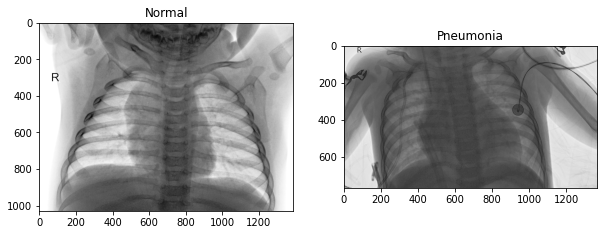

In [5]:
# Visualizing 1 random image in each train folder

# Normal image 

print("Number of files on directory: " + str(len(os.listdir(train_normal)))) # printing number of files in the directory

rand_normal = np.random.randint(0,len(os.listdir(train_normal))) # choosing a random number
normal_pic = os.listdir(train_normal)[rand_normal] # choosing image based on random number
normal_pic_address = train_normal + normal_pic # path to the image
print('Normal lungs image: ',normal_pic) # print

# Pneumonia image

rand_pneumonia = np.random.randint(0,len(os.listdir(train_pneumonia))) # choosing a random number
pneumonia_pic =  os.listdir(train_pneumonia)[rand_pneumonia] # choosing image based on random number
pneumonia_pic_address = train_pneumonia + pneumonia_pic # path to the image
print('Pneumonia lungs image:', pneumonia_pic) # print

# Load the images

normal_load = Image.open(normal_pic_address)
pneumonia_load = Image.open(pneumonia_pic_address)

# Use matplotlib to plot the images

f = plt.figure(figsize= (10,6))

a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(normal_load, cmap='Greys') # the default cmap is viridis, changed to grey
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(pneumonia_load, cmap='Greys')
a2.set_title('Pneumonia')

In [6]:
# Pre-processing images for training, validation and test datasets 

# Applying the same pre-processing used on vgg16

# Image target_size=(224,224)

# Data augmentation parameters used:

# shear_range = 0.2, helps to transform the image by slightly changing its shape relative to a given point 
# zoom_range = 0.2, will randomly zoom inside images
# vertical_flip = False, as X-ray images are not created upside down 

# Model parameters:

# batch_size=32
# shuffle=False, for test set only as I need to access the right labels at a later stage

train_batches = ImageDataGenerator(shear_range = 0.2, zoom_range = 0.2, vertical_flip = False, preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['NORMAL', 'PNEUMONIA'], batch_size=32, \
                         )
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['NORMAL', 'PNEUMONIA'], batch_size=32, \
                         )
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['NORMAL', 'PNEUMONIA'], batch_size=32, \
                         shuffle=False)

Found 5249 images belonging to 2 classes.
Found 276 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

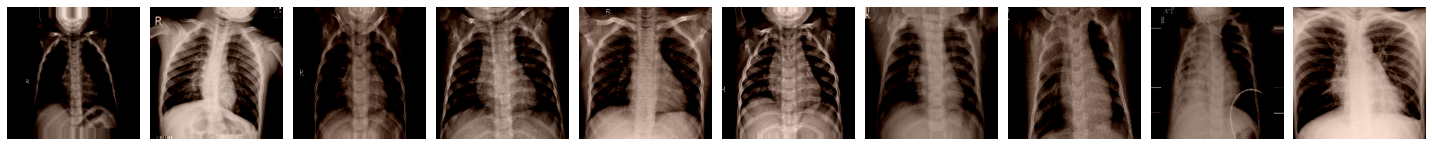

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [7]:
# Grab a sample of images from the train batch for visualization
# It will take the batch size that was specified above

imgs, labels = next(train_batches)

# Taken directly from tensor flow website. Standard code to plot images

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(np.array(img/np.amax(img)*255, np.int32))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    
# Plot the images
# Limiting the output to only 10 images

plotImages(imgs[:11])
print(labels[:11])

In [8]:
# Code below is useful to understand the shape of the the input

# Color mode: It describes the color format of the images, i.e. GRAY, RGB, or RGBA...
# The color format is represented by channels  1, 3, or 4 and it's the last value of the tuple.

# Channel 1 – GRAY format
# Channel 3 – RGB format
# Channel 4 – RGBA format

for img in imgs[:1]:
    print(img.shape)

(224, 224, 3)


In [9]:
# Build the model 

# learning_rate=0.0001
# activation='softmax'
# optimizer=Adam

# First Conv2D layer:
# 32 output filters each with a kernel size of 3x3, and using the relu activation function

# Second Conv2D layer:
# 64 output filters each with a kernel size of 3x3, and using the relu activation function

# Both convolution layers followed by a MaxPool2D layer with poo_size 2x2 and stride of 2

model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax') # this is the output layer specifying Pnemonia vs. No-Pnemonia values
])

# Compile the model

# Create F1 score metric


def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', f1_metric])

# Get model summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [10]:
# Train the model with patiente early stopping

# Patient early stopping
# Will allow training to continue for up to an additional 10 epochs

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Save the best model over training based on accuracy

mc = ModelCheckpoint('models/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Fit the model 

# note: data is specified as a generator, thus no need to specify y (it is contained in the generator itself)

history = model.fit(x=train_batches,
    steps_per_epoch=len(train_batches), # became a mandatory parameter
    validation_data=valid_batches,
    validation_steps=len(valid_batches), # became a mandatory parameter
    epochs=50,
    verbose=2, # most verbose output
    callbacks=[es, mc] # for early stopping and saving best model  
)

Epoch 1/50

Epoch 1: val_accuracy improved from -inf to 0.93478, saving model to models/best_model.h5
165/165 - 127s - loss: 1.3061 - accuracy: 0.8607 - f1_metric: 0.8557 - val_loss: 0.2176 - val_accuracy: 0.9348 - val_f1_metric: 0.9333 - 127s/epoch - 767ms/step
Epoch 2/50

Epoch 2: val_accuracy improved from 0.93478 to 0.94565, saving model to models/best_model.h5
165/165 - 109s - loss: 0.2816 - accuracy: 0.9192 - f1_metric: 0.9197 - val_loss: 0.1624 - val_accuracy: 0.9457 - val_f1_metric: 0.9417 - 109s/epoch - 661ms/step
Epoch 3/50

Epoch 3: val_accuracy improved from 0.94565 to 0.96377, saving model to models/best_model.h5
165/165 - 109s - loss: 0.1803 - accuracy: 0.9400 - f1_metric: 0.9403 - val_loss: 0.1072 - val_accuracy: 0.9638 - val_f1_metric: 0.9590 - 109s/epoch - 658ms/step
Epoch 4/50

Epoch 4: val_accuracy did not improve from 0.96377
165/165 - 110s - loss: 0.1634 - accuracy: 0.9461 - f1_metric: 0.9464 - val_loss: 0.1567 - val_accuracy: 0.9348 - val_f1_metric: 0.9333 - 110s/

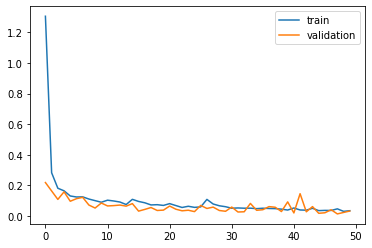

In [11]:
# Plot training history

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [16]:
# Load the model

pneumonia_detection = load_model('models/best_model.h5', custom_objects={"f1_metric": f1_metric})

In [17]:
# Make predictions

predictions = pneumonia_detection.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [18]:
# Verify the class mapping for confusion matrix

test_batches.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Confusion matrix, without normalization
[[172  62]
 [  6 384]]


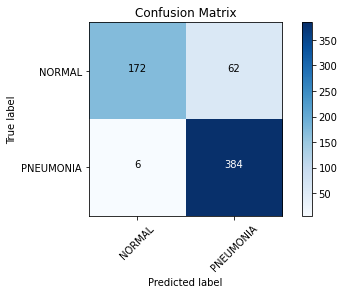

In [19]:
# Create confusion matrix

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

cm_plot_labels = ['NORMAL','PNEUMONIA'] # Define mapping

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix') # Plot the matrix

In [27]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("TPR: " + str(TPR[1]))
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("TNR: " + str(TNR[1]))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("PPV: " + str(PPV[1]))
# Negative predictive value
NPV = TN/(TN+FN)
print("NPV: " + str(NPV[1]))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print("FPR: " + str(FPR[1]))
# False negative rate
FNR = FN/(TP+FN)
print("FNR: " + str(FNR[1]))
# False discovery rate
FDR = FP/(TP+FP)
print("FDR: " + str(FDR[1]))

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("ACC: " + str(ACC[1]))

TPR: 0.9846153846153847
TNR: 0.7350427350427351
PPV: 0.8609865470852018
NPV: 0.9662921348314607
FPR: 0.26495726495726496
FNR: 0.015384615384615385
FDR: 0.13901345291479822
ACC: 0.8910256410256411
